In [10]:
!pip install -r requirements.txt

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached torchmetrics-0.11.1-py3-none-any.whl (517 kB)
  Using cached paddleocr-2.6.1.2-py3-none-any.whl (440 kB)
  Using cached paddlepaddle-2.4.1-cp38-cp38-manylinux1_x86_64.whl (121.6 MB)
  Using cached segmentation_models_pytorch-0.3.2-py3-none-any.whl (106 kB)
  Using cached matplotlib-3.6.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached pandas-1.5.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
ERROR: matplotlib 3.6.3 has requirement numpy>=1.19, but you'll have numpy 1.18.0 which is incompatible.
ERROR: pandas 1.5.3 has requirement numpy>=1.20.3; python_version < "3.10", but you'll have numpy 1.18.0 which is incompatible.


In [1]:
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT
import warnings
warnings.filterwarnings("ignore")
from pipeline import segmentation
from pipeline import correct_perspective
from pipeline import OCR
from pipeline import vitals_detector
import os
import re
import cv2
import json
import numpy as np
np.int=int
import matplotlib.pyplot as plt
from collections import defaultdict
from multiprocess import Pool
import matplotlib.image as mpimg
import PlotDigitizerModule
from PlotDigitizerModule.plotdigitizer import run
import seaborn as sns
pool = Pool(processes=7)
%matplotlib inline

[2023/02/07 21:27:58] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/drobot/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/drobot/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.4, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_p

YOLOv5 🚀 v7.0-72-g064365d8 Python-3.8.10 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 1768636 parameters, 0 gradients
Adding AutoShape... 


### INFERENCE FUNCTION


- We are predicting MAP as well, most of the time it will able to detect MAP

In [6]:
def vital_info(crop_info):
    return (crop_info["label"].split(" ")[0], OCR.get_text(crop_info["im"], det=False)[0][0][0], crop_info["conf"].item(), crop_info["box"], crop_info["im"])


def inference(image_path):
    if isinstance(image_path, str):
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    else:
        image = image_path
    # ocr_io = cv2.resize(image, (320, 180))
    # class_io = cv2.resize(image, (640, 360))

    results = {}
    mask = segmentation.maskPred(image)
    detector_io =  correct_perspective.correctPerspective(image, mask)
    img_graph = detector_io.copy()
    vitals = vitals_detector.get_vitals(detector_io)
    # print(vitals.crop(save=False))
    # plt.imshow(image)
    # plt.show()
    # plt.imshow(detector_io)
    # plt.show()


    ### USED MULTI-THREADING FOR PARALLELIZING RECOGNITION IN PADDLE OCR (INCREASED SPEED UPTO 2.5X)
    ocr_op_info = pool.map(vital_info, vitals.crop(save=False))
    
    # vitals.show()
    # print(ocr_op_info)
    vital_dict = defaultdict(list)
    
    for i in ocr_op_info:
        v, t, conf, bbox = i[0], i[1], i[2], i[3]
        t = str(t)
        t = re.sub('[^0-9]','', t)
        vital_dict[v].append([t, conf, list(map(lambda x: int(x.item()), bbox))])

    hr_box = None
    if len(vital_dict['HR']) == 1:
        results['HR'] = vital_dict['HR'][0][0]
        hr_box = vital_dict['HR'][0][2]
    else :
        conf = 0
        for hr in vital_dict['HR']:
            if conf < hr[1]:
                results['HR'] = hr[0]
                conf = hr[1]
                hr_box = hr[2]
    
    if len(vital_dict['SPO2']) == 1:
        results['SPO2'] = vital_dict['SPO2'][0][0]
    else :
        conf = 0
        for hr in vital_dict['SPO2']:
            if conf < hr[1]:
                results['SPO2'] = hr[0]
                conf = hr[1]

    if len(vital_dict['MAP']) == 1:
        results['MAP'] = vital_dict['MAP'][0][0]
    else :
        conf = 0
        for hr in vital_dict['MAP']:
            if conf < hr[1]:
                results['MAP'] = hr[0]
                conf = hr[1]
    
    # print(vital_dict)
    if len(vital_dict['RR']) == 1:
        results['RR'] = vital_dict['RR'][0][0]
    else :
        conf = 0
        for hr in vital_dict['RR']:
            if conf < hr[1]:
                results['RR'] = hr[0]
                conf = hr[1]

    if len(vital_dict['SBP']) == 1:
        results['SBP'] = vital_dict['SBP'][0][0]
    else :
        conf = 0
        for hr in vital_dict['SBP']:
            if conf < hr[1]:
                results['SBP'] = hr[0]
                conf = hr[1]
    
    if len(vital_dict['DBP']) == 1:
        results['DBP'] = vital_dict['DBP'][0][0]
    else :
        conf = 0
        for hr in vital_dict['DBP']:
            if conf < hr[1]:
                results['DBP'] = hr[0]
                conf = hr[1]

    

    distance = image.shape[0]*image.shape[1]
    sbp_dbp = []
    for sbp in vital_dict['SBP']:
        x1, y1, x2, y2 = sbp[2]
        x = (x1+x2)/2
        y = (y1+y2)/2
        for dbp in vital_dict['DBP']:
            x_1, y_1, x_2, y_2 = dbp[2]
            X = (x_1+x_2)/2
            Y = (y_1+y_2)/2
            if x < X:
                if y < Y:
                    if max(y1, y2) > min(y_1, y_2):
                        sbp_dbp.append([sbp, dbp])
                else:
                    if min(y1, y2) < max(y_1, y_2):
                        sbp_dbp.append([sbp, dbp])
    
    max_conf = 0        
    for pairs in sbp_dbp:
        sbp = pairs[0]
        dbp = pairs[1]

        p1, p2 = sbp[1], dbp[1]
        if (p1 + p2) > max_conf:
            max_conf = p1 + p2
            results['SBP'] = sbp[0]
            results['DBP'] = dbp[0]

    
    if len(vital_dict['HR_W'])>0:
        conf = 0
        for hr_w in vital_dict['HR_W']:
            if conf > hr_w[1]:
                x1, y1, x2, y2 = hr_w[2]
                cropped = img_graph[y1:y2, x1:x2]
                cv2.imwrite("results/HR_graph.jpg", cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR)) ## saved the HR Graph for additional digitization
                conf = hr_w[1]

    if hr_box is not None :
        x_1, y_1, x_2, y_2 = hr_box
        X, Y = (x_1+x_2)/2, (y_1+y_2)/2
        for hr_w in vital_dict['HR_W']:
            x1, y1, x2, y2 = hr_w[2]
            x, y = (x1 + x2)/2, (y1 + y2)/2
            if distance > (x-X)*(x-X) + (y-Y)*(y-Y):
                distance = (x-X)*(x-X) + (y-Y)*(y-Y)
                cropped = img_graph[y1:y2, x1:x2]
                cv2.imwrite("results/HR_graph.jpg", cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
                

    ## checking for empty key value (if any, then remove it)
    # print(results)
    results = {key: results[key] for key in results if results[key] != ''}
    return results

#### Add image path in next cell

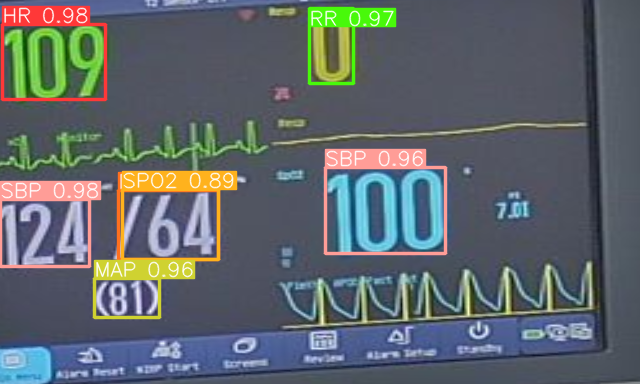

Vitals -  {'HR': '109', 'SPO2': '64', 'MAP': '81', 'RR': '0', 'SBP': '124', 'DBP': '64'}
CPU times: user 3.74 s, sys: 38.7 ms, total: 3.78 s
Wall time: 699 ms


In [5]:
%%time

## EVALUATION ON EACH IMAGE
TEST_IMG_DIR = "test_data"

imlis = os.listdir(TEST_IMG_DIR)
image_path = f"{TEST_IMG_DIR}/{imlis[6]}"

## RUN INFERENCE FUNCTION
vitals = inference(image_path)

print("Vitals - ", vitals)

**Our Pipeline able to generate results within 0.6-1 seconds, and with a good accuracy** 

### ADDITIONAL (HR GRAPH DIGITIZATION)

In [82]:
def digitize_graph(image_path, plot_img_name='results/HR_digitize.png'):
    points = run(img_path=image_path, plot=plot_img_name)
    x = [float(p[0]) for p in points]
    y = [float(p[1]) for p in points]
    plt.rcParams["figure.figsize"] = [10.00, 3]
    plt.rcParams["figure.autolayout"] = True

    # sns.lineplot(data=[x, y])
    # plt.subplot(211)
    # plt.plot(x, y)
    # plt.show()

    # plt.subplot(212)
    # plt.imshow(mpimg.imread(image_path), aspect='auto')
    # plt.show()

In [83]:
#for graph
digitize_graph('results/HR_graph.jpg')

### Visualisation of Results

**We used Gradio, which helps in providinng a frontend for running visualisation of our Approach**

- It takes input image and return the results extracted along with hr digitized graph

- Run below cells to get the visualisation frontend

In [87]:
def wrapper(image_path):
    '''
    wrapper for gradio
    '''
    rs = inference(image_path)
    digitize_graph("results/HR_graph.jpg")
    return (json.dumps(rs), plt.imread('results/HR_digitize.png'))
    

In [88]:

import gradio as gr

html = """<div style="display: flex; justify-content: space-evenly; align-items: center; font-family: 'Courier New', Courier, monospace;"><img src="https://cloudphysician.net/assets/logo.svg" alt="Logo" style="width: 50%;">
        <div class="desc" style="flex-direction: column; width: 50%;">
            <h4>THE VITAL EXTRACTION CHALLENGE</h4>
            <p>Patient monitoring is a crucial aspect of healthcare, as it allows healthcare professionals to closely track a patient's vital signs and detect any potential issues before they become serious. Here, we extract information like Heart rate, SpO2, RR, Systolic Blood Pressure, Diabolic Blood pressure and MAP from the input images of the monitor.</p>
        </div>
    </div>"""

io = gr.Interface(
    wrapper, 
    inputs=[gr.Image()], 
    outputs=["json", "image"],
    description=html,
    allow_flagging='never',
)

io.dependencies[0]["show_progress"] = False

io.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.
